In [160]:
from fxdata import load_ticker, pip_factor
from indicators import SMA, EMA
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
#%matplotlib notebook
%matplotlib inline

### M7 Impersonator
Idea:  
* Every (interval), place a small trade that you think we hit +TP before hitting -TP.  
* If it hits -TP, place another, bigger trade in the same direction.   
* Keep going until profit reached or max DD hit.

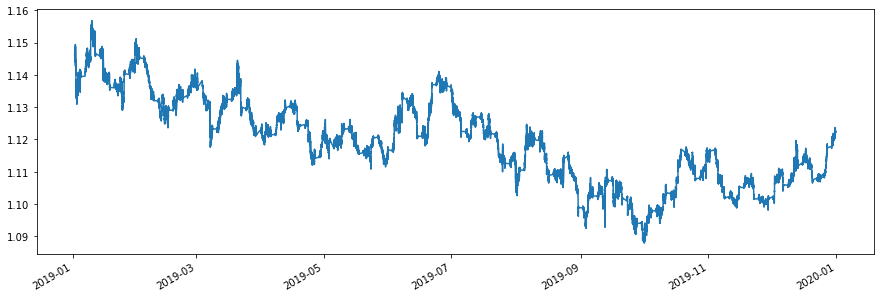

In [2]:
df = load_ticker("EURUSD_train")
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)
df.Close.plot(figsize=(15, 5))

#### Up or down task
From the open of a bar, will it hit X pips Up or X pips down first?  
Lets make a new column, called X_pips_dir, 1 == Up and -1 == Down

We can use 0 to be not yet determined, then we shift and compare the Open price of this bar to the High and Low of the shifted bar. If the value is X pips more or less, and the current value is 0, we can set the direction and the time, need a column X_pips_time to be the number of (lag units) until it is reached.

In [27]:
ticker = "EURUSD"
def pip_search(df, pips, ticker, max_lag=1000):
    pip_value = pips / pip_factor(ticker)
    dir_col = f"{pips}_pips_dir"
    time_col = f"{pips}_pips_time"
    df[dir_col] = 0
    df[time_col] = -1

    for lag in range(max_lag):
        df["High_shift"] = df.High.shift(-lag) - df.Open
        df["Low_shift"] = df.Open - df.Low.shift(-lag)

        df.loc[(df['High_shift'] >= pip_value) & (df[dir_col] == 0), time_col] = lag
        df.loc[(df['High_shift'] >= pip_value) & (df[dir_col] == 0), dir_col] = 1
        df.loc[(df['Low_shift'] >= pip_value) & (df[dir_col] == 0), time_col] = lag
        df.loc[(df['Low_shift'] >= pip_value) & (df[dir_col] == 0), dir_col] = -1

    df.drop(columns=['High_shift', 'Low_shift'], inplace=True)
    return df

#### How many levels calculation
Given a pip value X, if you chose the wrong direction every minute, how many levels would you need to go before it righted. This gives a numerical value of the risk. Any signal generator should concentrate on getting the high level points right, or recognising the risk and not trading.  

Given a row, how do I determine the levels for this row. I can determine the price levels straight away from the Open. I know the optimal direction, so I know the wrong way. When does it hit one level down? From there, does it go one level up first or one level down first. How about a data structure indexed with price, each price has a list of times it was crossed. Then, say I know the value V at time T, I want to know if it hits V+X or V-X first.  

Data strucure:  
identify how may bins (high max - min low * 1/pip_factor)
Each bin is a list, num minutes since start.  Can use binary search to find the closest time after the start time in log(W), W is the length of the list.


In [133]:
dd = df.copy()
dd.insert(0, 'Minute', range(len(dd)))

ticker = "EURUSD"
max_val = df.High.max()
min_val = df.Low.min()

buckets = int((max_val - min_val) * pip_factor(ticker) + 0.5) + 1

def to_bucket(price):
    bucket = int((price - min_val) * pip_factor(ticker) + 0.5)
    if bucket < 0:
        #print(f"WARN: Bucket {bucket} < 0")
        bucket = 0
    if bucket >= buckets:
        #print(f"WARN: Bucket {bucket} >= Buckets {buckets}")
        bucket = buckets - 1
    return bucket

pt = [[] for x in range(buckets)]

for idx, row in dd.iterrows():
    low_bucket = to_bucket(row.Low)
    high_bucket = to_bucket(row.High)
    for i in range(low_bucket, high_bucket + 1):
        pt[i].append(int(row.Minute))
#print(pt)

In [136]:
from bisect import bisect_left
def closest_next(minute, price):
    bucket = to_bucket(price)
    idx = bisect_left(pt[bucket], minute)
    if idx == 0:
        return pt[bucket][0]
    if idx == len(pt[bucket]):
        return pt[bucket][-1]
    return pt[bucket][idx]



In [155]:
pip_val = 5 / pip_factor(ticker)

def direction(price, minute):
    direction = 0
    up = price + pip_val
    down = price - pip_val
    up_t = closest_next(minute, up)
    down_t = closest_next(minute, down)
    fast = 0
    slow = 0
    
    if up_t < down_t:
        direction = 1
        slow = down_t
        fast = up_t
    if down_t < up_t:
        direction = -1
        slow = up_t
        fast = down_t
    return direction, fast, slow 
        
all_levels = []

for idx, row in dd.iterrows():
    price = row.Open
    minute = row.Minute
    initial_dir, _, minute = direction(price, minute)
    levels = 1
    max_levels = 6
    
    found = False
    for _ in range(max_levels):
        price = price - (initial_dir * pip_val)
        
        if price > max_val or price < min_val:
            all_levels.append(-1)
            found = True
            break

            
        new_dir, _, minute = direction(price, minute)
        levels += 1

        if new_dir == initial_dir:
            all_levels.append(levels)
            found = True
            break
            
    if not found:
        all_levels.append(-2)
            
# TODO: If we fall outside the 
            

WARN: Bucket 694 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 693 >= Buckets 691
WARN: Bucket 691 >= Buckets 691
WARN: Bucket 691 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 692 >= Buckets 691
WARN: Bucket 691 >= Buckets 691
WARN: Bucket 691 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 694 >= Buckets 691
WARN: Bucket 695 >= Buckets 691
WARN: Bu

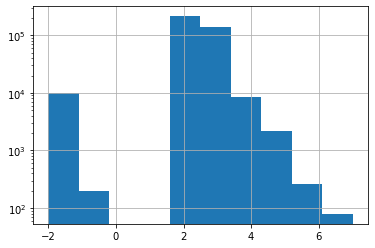

In [161]:
pd.Series(all_levels).hist(bins=10, log=True)

In [67]:
def pip_search2(df, pips, ticker, max_lag=1000):
    pip_value = pips / pip_factor(ticker)
    dir_col = f"{pips}_pips_dir"
    up_time_col = f"{pips}_up_pips_time"
    down_time_col = f"{pips}_down_pips_time"

    df[dir_col] = 0
    df[up_time_col] = -1
    df[down_time_col] = -1


    for lag in range(max_lag):
        df["High_shift"] = df.High.shift(-lag) - df.Open
        df["Low_shift"] = df.Open - df.Low.shift(-lag)

        df.loc[(df['High_shift'] >= pip_value) & (df[dir_col] == 0), up_time_col] = lag
        df.loc[(df['Low_shift'] >= pip_value) & (df[dir_col] == 0), down_time_col] = lag
    df.loc[df[up_time_col] < df[down_time_col], dir_col] = 1
    df.loc[df[up_time_col] > df[down_time_col], dir_col] = -1

    

    df.drop(columns=['High_shift', 'Low_shift'], inplace=True)
    return df

In [68]:
pips = 10
df = pip_search(df, pips, "EURUSD", 200)

<IPython.core.display.Javascript object>


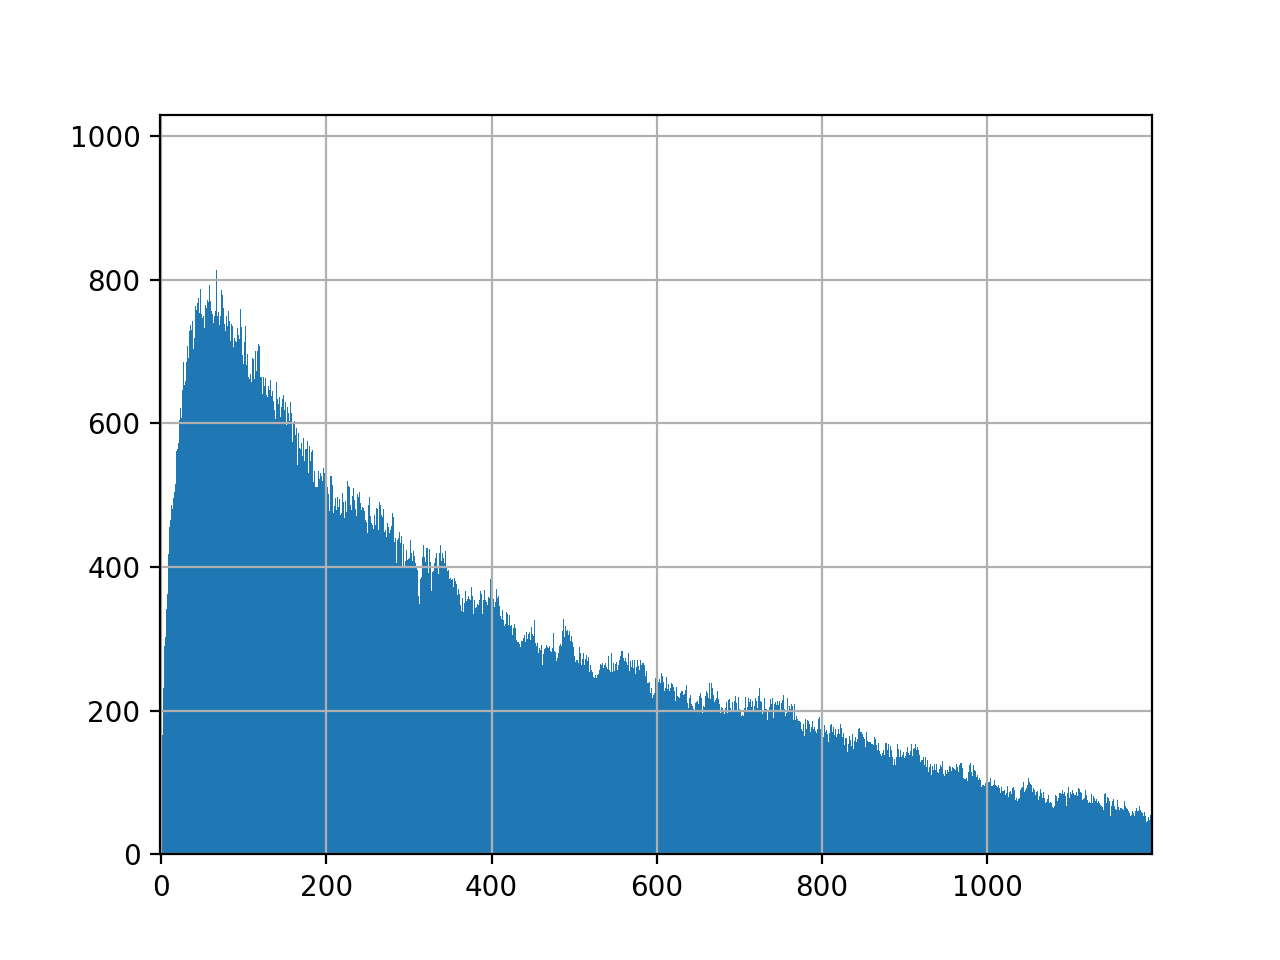

In [34]:
df[f"{pips}_up_pips_time"].hist(bins=1200)

Nice! This looks like a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), play with it [here](https://www.desmos.com/calculator/7hc21rk096). I wonder if I did the same analysis with a random walk if it would have the same distribution?

|Pips|Peak (mins)|
|----|----|
|  5 |  5 |
| 10 | 30 |
| 15 | 60 |
| 20 | 120|

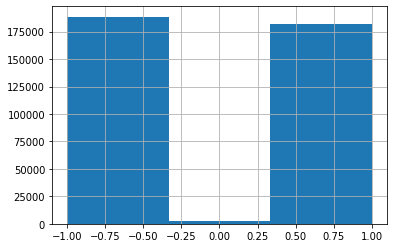

In [14]:
df["10_pips_dir"].hist(bins=3)

<IPython.core.display.Javascript object>


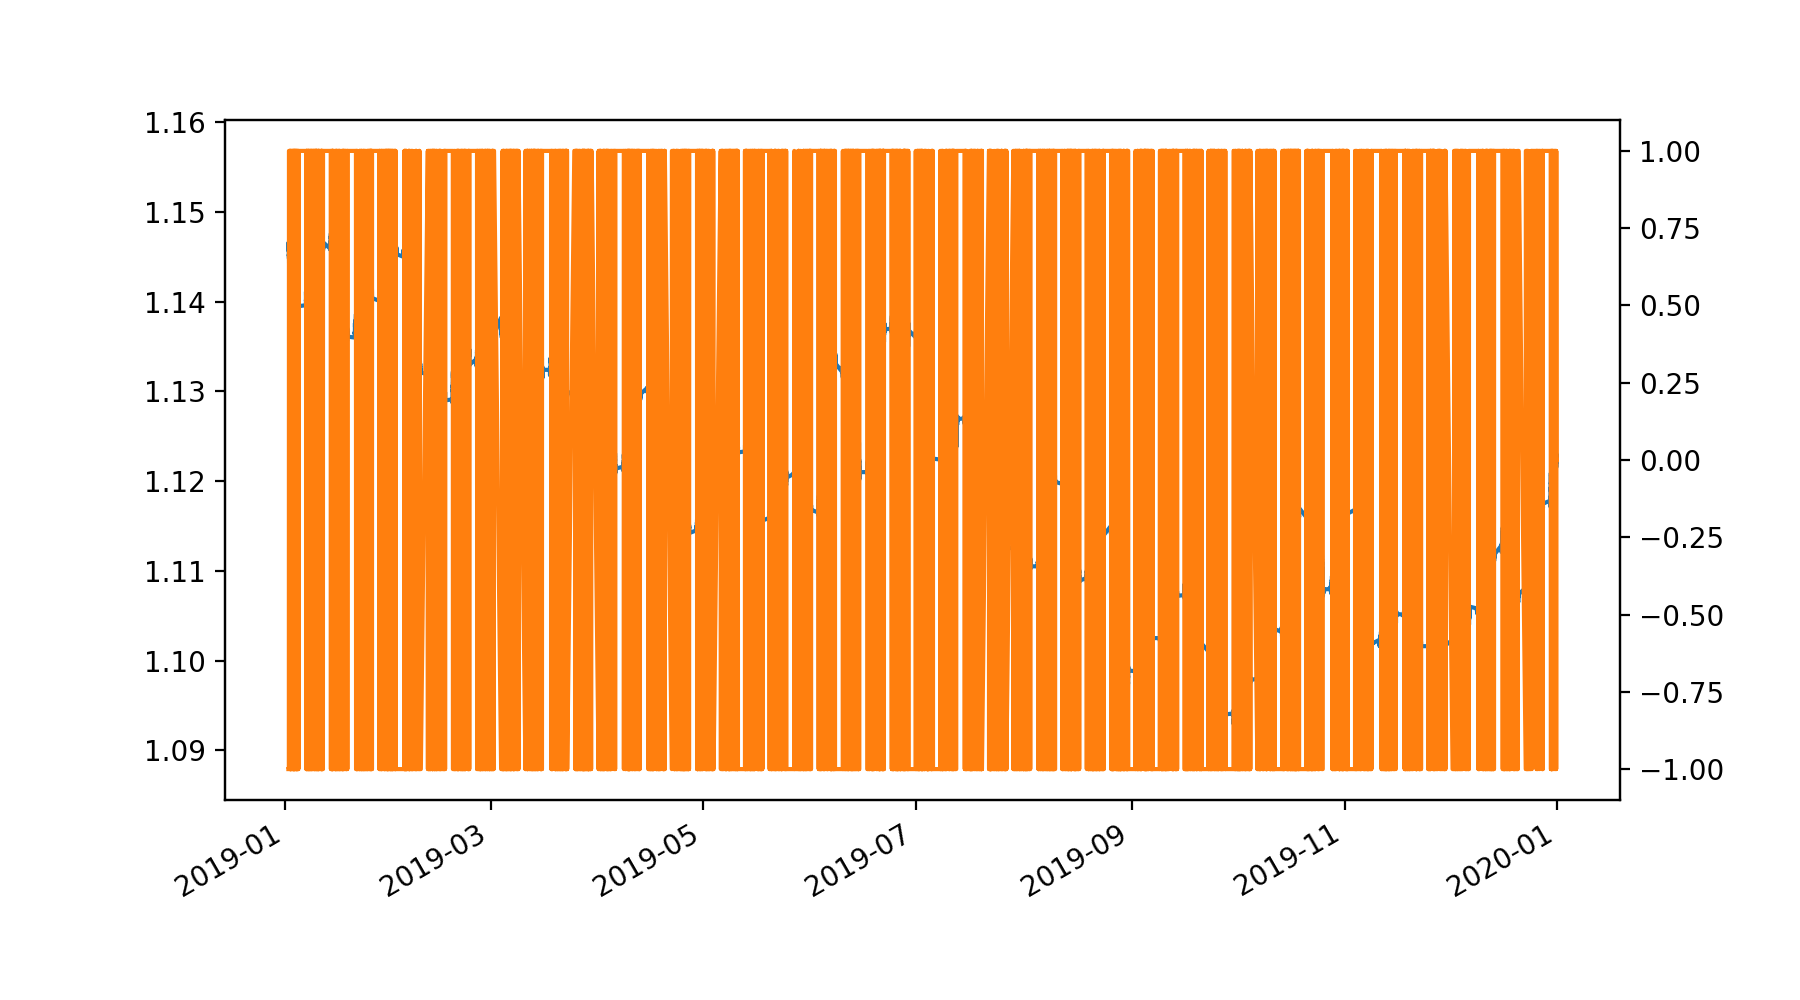

In [39]:
df.Close.plot(figsize=(9, 5))
df["10_pips_dir"].plot(secondary_y=True)

### SMA

In [62]:
target = "SMA"
period = 100
base = "Close"

for period in range(100, 1000, 10):
    df = SMA(df, base, target, period)
    df["SMA_1"] = np.where(df["SMA"] > df["SMA"].shift(-1), 1, -1)
    print(period, f1_score(df["10_pips_dir"], df["SMA_1"], average="micro"))
    df.drop("SMA",axis=1, inplace=True)

100 0.5031769338762888
110 0.5039043940203313
120 0.5037191735408518
130 0.503890972246456
140 0.5037540701529277
150 0.5050828257665846
160 0.5046050106166231
170 0.5045486391663467
180 0.5044224744919188
190 0.5053029428581399
200 0.5054801102732942
210 0.5056572776884484
220 0.5055203755949201
230 0.5055203755949201
240 0.5066665950838727
250 0.5064679528305179
260 0.5071846755554601
270 0.506843762499027
280 0.5071309884599589
290 0.506849131208577
300 0.507635647157671
310 0.5073752647444897
320 0.5065672739571953
330 0.5070343516880566
340 0.5070343516880566
350 0.5068034971774009
360 0.5060652996142582
370 0.5057592831699008
380 0.5063766847681657
390 0.5059445036493803
400 0.5058290763940525
410 0.5057324396221502
420 0.5050774570570344
430 0.5041325641762118
440 0.5030454004923106
450 0.5030454004923106
460 0.5024172614749456
470 0.501813281650556
480 0.5009623411868607
490 0.5004630511986986
500 0.4999718142748618
510 0.4995262113822011
520 0.49909403026341576
530 0.498930284

In [65]:
target = "EMA"
period = 100
base = "Close"

for period in range(100, 1000, 10):
    df = EMA(df, base, target, period)
    df["EMA_1"] = np.where(df["EMA"] > df["EMA"].shift(-1), 1, -1)
    print(period, f1_score(df["10_pips_dir"], df["EMA_1"], average="micro"))
    df.drop("EMA",axis=1, inplace=True)

100 0.49867527091850566
110 0.4994268902555237
120 0.5002321966880431
130 0.4998000155692577
140 0.5002402497523682
150 0.5008039642551319
160 0.501058977958763
170 0.5018401251983067
180 0.5020199769682361
190 0.5019099184224584
200 0.5027742806600292
210 0.5028118616268801
220 0.5026212724378505
230 0.502685696952452
240 0.5027232779193029
250 0.5019689742275099
260 0.5015367931087245
270 0.5013649944031203
280 0.501437471982047
290 0.5010079752180367
300 0.5008254390933323
310 0.5007019587736794
320 0.5006616934520534
330 0.5003234647503952
340 0.5005274757133001
350 0.5001650878186664
360 0.5000765041110894
370 0.5004415763604981
380 0.5005355287776254
390 0.5002509871714685
400 0.4998885992768348
410 0.4999852360487371
420 0.5000389231442385
430 0.5004039953936472
440 0.5002563558810187
450 0.5002536715262436
460 0.5009516037677604
470 0.5007234336118799
480 0.5003422552338207
490 0.49985638701953405
500 0.4993463596122718
510 0.49916919219711753
520 0.4993302534836214
530 0.49983

Lets try a simple one, if this SMA is greater than the last, it is a buy, if it is less, it is a sell

In [44]:
df.head

<bound method NDFrame.head of                        Open    High     Low   Close  10_pips_dir  \
2019-01-01 22:01:00  1.1463  1.1463  1.1463  1.1463           -1   
2019-01-01 22:02:00  1.1463  1.1463  1.1463  1.1463           -1   
2019-01-01 22:03:00  1.1463  1.1463  1.1463  1.1463           -1   
2019-01-01 22:04:00  1.1463  1.1463  1.1463  1.1463           -1   
2019-01-01 22:05:00  1.1463  1.1463  1.1463  1.1463           -1   
...                     ...     ...     ...     ...          ...   
2019-12-31 18:55:00  1.1224  1.1224  1.1223  1.1224            0   
2019-12-31 18:56:00  1.1223  1.1223  1.1223  1.1223            0   
2019-12-31 18:57:00  1.1223  1.1223  1.1223  1.1223            0   
2019-12-31 18:58:00  1.1223  1.1223  1.1223  1.1223            0   
2019-12-31 18:59:00  1.1223  1.1223  1.1222  1.1222            0   

                     10_pips_time  5_pips_dir  5_pips_time  20_pips_dir  \
2019-01-01 22:01:00           157          -1          122           -1   
201

0.4896021517787877

In [1]:
[x for x in range(6)]

[0, 1, 2, 3, 4, 5]